In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
#### based on clinical data

join_df = pd.read_csv('extdata/cn_emci_lmci_ad_clin_pseudotime.csv')

In [5]:
import sys
sys.path.append('./clintra')

from importlib import reload  

import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

from clintraj_qi import *
from clintraj_util import *
from clintraj_optiscale import *

/nfs/med-dcmb-software/modules/x86_64/master/anaconda3/2020.07/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/nfs/med-dcmb-software/modules/x86_64/master/anaconda3/2020.07/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [6]:
df = join_df

In [7]:
####### remove old clin vars
df = df.drop(columns=['SNF', 'AGE', 'PTGENDER', 'PTEDUCAT','PTRACCAT', 'PTMARRY', 'APOE4'])

In [9]:
variable_types, binary, continuous, ordinal = detect_variable_type(df,10,verbose=False)

In [10]:
dfq,replacement_info = quantify_dataframe_univariate(df,variable_types)
with open('temp.txt','w') as fid:
    fid.write(replacement_info)

Matrix shape: (1213, 13)
Effective linear dimension 2
Full matrix shape (1274, 13)


,PID,CDRSB,ADAS11,ADAS13,ADASQ4,MMSE,RAVLT_immediate,RAVLT_learning,RAVLT_forgetting,RAVLT_perc_forgetting,LDELTOTAL,TRABSCOR,FAQ,SNFSUB
0,002_S_0295,-2.220446e-16,3.00,4.000000,1.0,28.0,56.0,5.0,3.0,23.07690,12.0,300.000000,0.0,0
1,002_S_0413,-2.220446e-16,3.33,4.330000,1.0,29.0,52.0,6.0,5.0,41.66670,12.0,55.000000,0.0,0
2,002_S_0559,-2.220446e-16,6.00,8.000000,2.0,30.0,48.0,5.0,1.0,9.09091,15.0,53.000000,0.0,0
3,002_S_0685,-2.220446e-16,3.67,6.670000,3.0,30.0,36.0,5.0,3.0,33.33330,13.0,67.000000,0.0,0
4,002_S_1261,-2.220446e-16,6.00,8.000000,2.0,30.0,55.0,9.0,4.0,26.66670,17.0,71.000000,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1269,127_S_5067,4.500000e+00,21.00,32.000000,10.0,23.0,17.0,3.0,5.0,100.00000,1.0,69.000000,15.0,5
1270,131_S_5138,2.000000e+00,14.00,21.000000,5.0,25.0,39.0,6.0,5.0,50.00000,7.0,129.744273,4.0,5
1271,053_S_5208,5.500000e+00,19.00,30.000000,10.0,26.0,32.0,2.0,7.0,100.00000,0.0,68.000000,23.0,5
1272,131_S_0691,6.000000e+00,42.67,54.670000,9.0,24.0,10.0,1.0,2.0,100.00000,1.0,150.000000,26.0,5


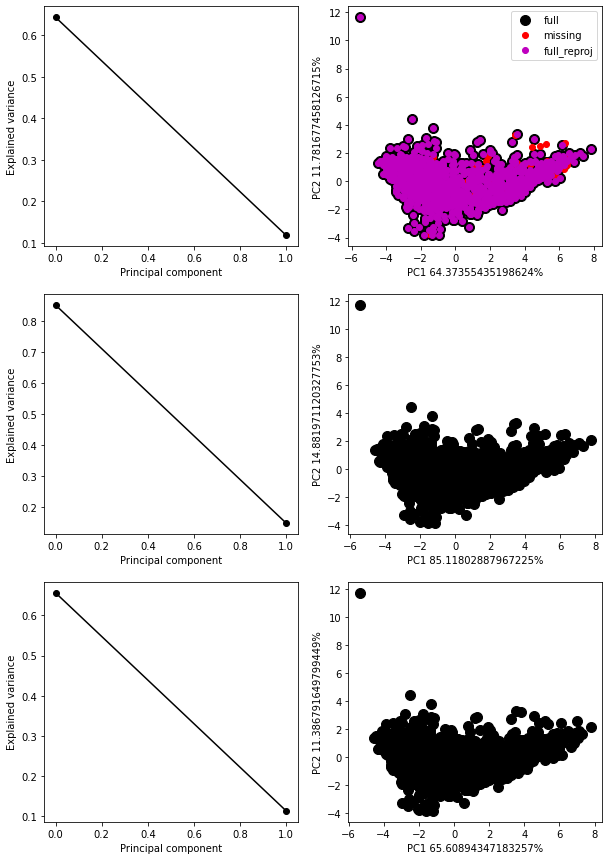

In [11]:
dfq_imputed = SVDcomplete_imputation_method(dfq, variable_types, verbose=True,num_components=-1)
#dequant_info = invert_quant_info(replacement_info)
dequant_info = invert_quant_info(load_quantification_info('temp.txt'))
df_imputed = dequantify_table(dfq_imputed,dequant_info)
display(df_imputed)

In [ ]:
df = remove_constant_columns_from_dataframe(df_imputed)
variable_names = [str(s) for s in df.columns[1:]]
X = df[df.columns[1:]].to_numpy()
X_original = X
X_before_scaling = X.copy()
X,cik = optimal_scaling(X,variable_types,verbose=True,vmax=0.6)

In [14]:
from clintraj_eltree import *
from clintraj_util import *
from clintraj_ml import *
from clintraj_optiscale import *

In [15]:
import elpigraph

In [16]:
reduced_dimension = 12
X = scipy.stats.zscore(X)
pca = PCA(n_components=X.shape[1],svd_solver='full')
Y = pca.fit_transform(X)
v = pca.components_.T
mean_val = np.mean(X,axis=0)
X = Y[:,0:reduced_dimension]

In [17]:
nnodes = 40 ### 40 is default value for the plots in fri meet and also for CN-emci1-emci2-lmci1-lmci2-ad
tree_elpi = elpigraph.computeElasticPrincipalTree(X,nnodes,
                                                  alpha=0.01,Mu=0.1,Lambda=0.05,
                                                  FinalEnergy='Penalized',Do_PCA=False)
tree_elpi = tree_elpi[0]
# some additional pruning of the graph
prune_the_tree(tree_elpi)
# extend the leafs to reach the extreme data points
tree_extended = ExtendLeaves_modified(X, tree_elpi, Mode = "QuantDists", ControlPar = .5, DoSA = False)

Removed 6 vertices and 6 edges


<ipython-input-18-3696f49c55f6>:4: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  report = pd.DataFrame(data={'CODE':report[report.columns[0]].astype(np.str),
<ipython-input-18-3696f49c55f6>:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  peaks = np.array(find_peaks(-x[:,1]))


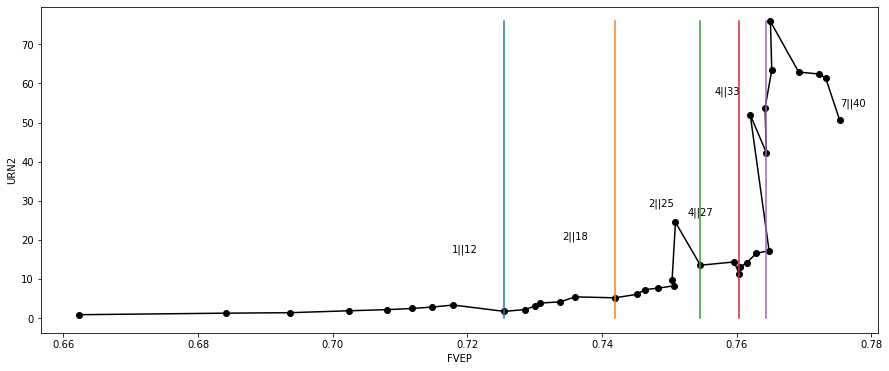

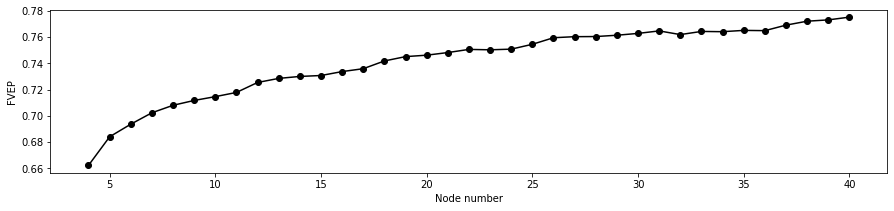

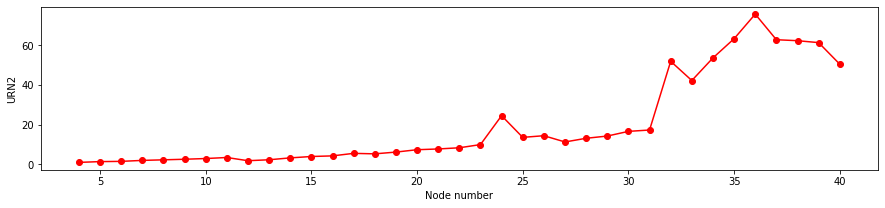

In [18]:
from scipy.signal import find_peaks

report = pd.DataFrame(data=tree_elpi['ReportTable'])
report = pd.DataFrame(data={'CODE':report[report.columns[0]].astype(np.str),
                       'FVEP':report['FVEP'].astype(np.float32),
                       'URN2':report['URN2'].astype(np.float32),
                       'NNODES':report['NNODES'].astype(np.float32)})
x = report[['FVEP','URN2','NNODES']].to_numpy()
codes = report['CODE']
plt.figure(figsize=(15,6))
plt.plot(x[:,0],x[:,1],'ko-')
plt.xlabel('FVEP')
plt.ylabel('URN2')
peaks = np.array(find_peaks(-x[:,1]))
for p in peaks[0]:
    plt.plot([x[p,0],x[p,0]],[0,np.max(x[:,1])])
    plt.text(x[p,0]-np.max(x[:,0]/100),x[p,1]+np.max(x[:,1])/5,codes[p])
plt.text(x[len(x)-1,0],x[len(x)-1,1]+np.max(x[:,1])/20,codes[len(x)-1])
plt.show()
plt.figure(figsize=(15,3))
plt.plot(x[:,2],x[:,0],'ko-')
plt.xlabel('Node number')
plt.ylabel('FVEP')
plt.show()
plt.figure(figsize=(15,3))
plt.plot(x[:,2],x[:,1],'ro-')
plt.xlabel('Node number')
plt.ylabel('URN2')
plt.show()

In [23]:
# paritioning the data by tree branches
vec_labels_by_branches = partition_data_by_tree_branches(X,tree_extended)
print(len(set(vec_labels_by_branches)),'labels generated')
# paritioning the data by proximity to nodes
nodep = tree_elpi['NodePositions']
partition, dists = elpigraph.src.core.PartitionData(X = X, NodePositions = nodep, 
                                                    SquaredX = np.sum(X**2,axis=1,keepdims=1),
                                                    MaxBlockSize = 100000000, TrimmingRadius = np.inf
                                                    )
partition_by_node = np.zeros(len(partition))
for i,p in enumerate(partition):
    partition_by_node[i] = p[0]

5 labels generated


In [ ]:
X.shape

In [ ]:
fig = plt.figure(figsize=(8, 8))
non_lethal_feature = 'SNFSUB'

visualize_eltree_with_data(tree_extended,X,X_original,'k',variable_names,
                            principal_component_vectors=v,mean_vector=mean_val,                           
                          Color_by_feature=non_lethal_feature, Feature_Edge_Width=non_lethal_feature,
                           Invert_Edge_Value=True,Min_Edge_Width=20,Max_Edge_Width=50,
                           Visualize_Edge_Width_AsNodeCoordinates=True,cmap='viridis')

plt.show()

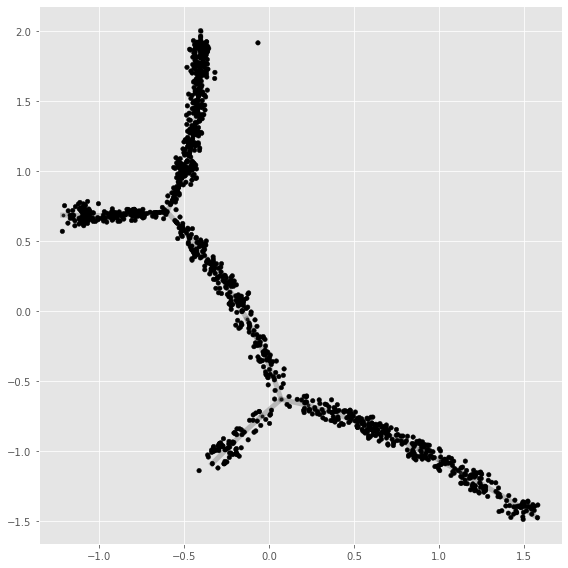

In [44]:
inds = np.where((X_original[:,variable_names.index('SNFSUB')]==6))[0]
fig = plt.figure(figsize=(8, 8))
colors = ['k' for i in range(len(X))]
for i in inds:
    colors[i] = 'r'
colors = list(colors)


#def visualize_eltree_with_data(tree_elpi,X,X_original,color,variable_names,principal_component_vectors=None,mean_vector=None,


visualize_eltree_with_data(tree_extended,X,X_original,colors,variable_names,
                          highlight_subset=inds,Big_Point_Size=100,cmap='hot')
#plt.show()
plt.tight_layout()
plt.savefig('figs/Figure_4B_pats.png', dpi=600)

['r'] [1274]


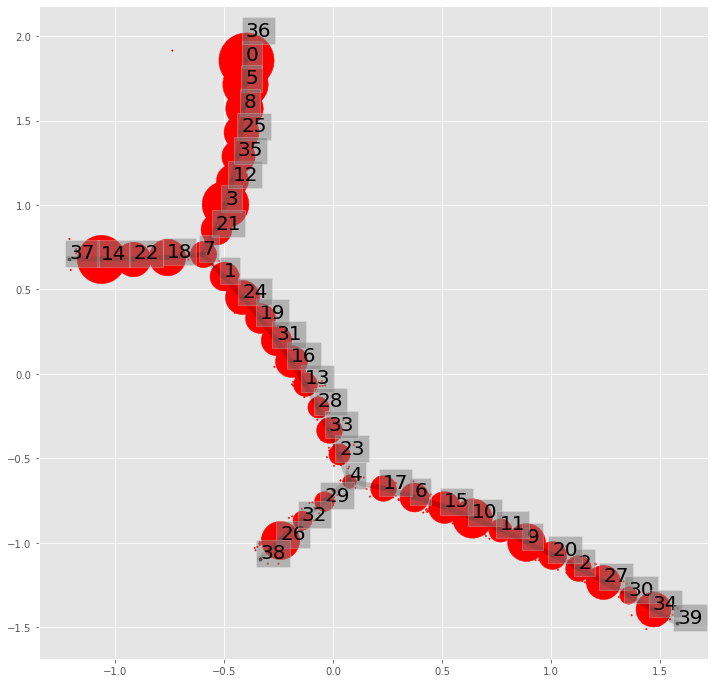

In [31]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1,1,1)


#complication_vars = ['AGE', 'PTGENDER', 'PTEDUCAT', 'PTRACCAT', 'PTMARRY', 'APOE4', 'CDRSB', 'ADAS11', 'ADAS13', 'ADASQ4', 'MMSE', 'RAVLT_immediate',  'RAVLT_learning', 'RAVLT_forgetting', 'RAVLT_perc_forgetting','LDELTOTAL', 'TRABSCOR', 'FAQ', 'SNFSUB']

complication_vars = ['CDRSB', 'ADAS11', 'ADAS13', 'ADASQ4', 'MMSE', 'RAVLT_immediate','RAVLT_learning', 'RAVLT_forgetting', 'RAVLT_perc_forgetting','LDELTOTAL', 'TRABSCOR', 'FAQ', 'SNFSUB']

inds_compl = [variable_names.index(a) for a in complication_vars]
lethal = 1-X_original[:,variable_names.index('SNFSUB')]
has_complication = np.sum(X_original[:,inds_compl],axis=1)>0
inds = np.where((has_complication==0)&(lethal==0))[0]
colors = ['r' for i in range(len(X))]
for i in inds:
    colors[i] = 'k'
visualize_eltree_with_data(tree_extended,X,X_original,colors,variable_names,
                            principal_component_vectors=v,mean_vector=mean_val,
                          highlight_subset=inds,Big_Point_Size=2,Normal_Point_Size=2,showNodeNumbers=True)
add_pie_charts(ax,tree_extended['NodePositions2D'],colors,['r','k'],partition,scale=30)
root_node = 0

plt.show()
#plt.tight_layout()
plt.savefig('figs/Figure_4B_all.png', dpi=600)
# print('Root node=',root_node)

In [32]:
all_trajectories,all_trajectories_edges = extract_trajectories(tree_extended,root_node)
print(len(all_trajectories),' trajectories found.')
ProjStruct = project_on_tree(X,tree_extended)
PseudoTimeTraj = quantify_pseudotime(all_trajectories,all_trajectories_edges,ProjStruct)

4  trajectories found.


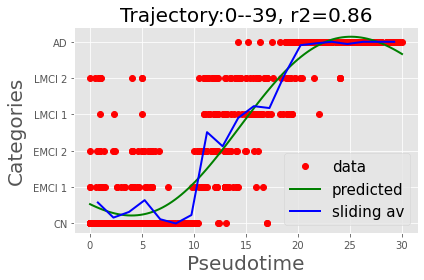

In [42]:
vars = ['SNFSUB']
for var in vars:
    List_of_Associations, plt = regression_of_variable_with_trajectories(PseudoTimeTraj,var,variable_names,
                                                                    variable_types,X_original,R2_Threshold=0.7,
                                                                    producePlot=True,
                                                                    Continuous_Regression_Type='gpr',
                                                                    verbose=False)
    
    
    plt.ylabel('Categories',fontsize=20)
    plt.yticks(ticks = [0,1,2,3,4,5] ,labels = ['CN','EMCI 1',' EMCI 2','LMCI 1','LMCI 2','AD',]) 
    plt.tight_layout()
    plt.savefig('figs/Figure_4D.png', dpi=600)


#plt.show()


In [ ]:
from clintraj_eltree import regression_of_variable_with_trajectories


R2_Threshold = 0.3
R2_Threshold_For_Complications = 0.1
#producePlot = True
all_trajectory_variable_associations = {}
complication_variables = ['AGE', 'PTGENDER', 'PTEDUCAT', 'PTRACCAT', 'PTMARRY', 'APOE4',
       'CDRSB', 'ADAS11', 'ADAS13', 'ADASQ4', 'MMSE', 'RAVLT_immediate',
       'RAVLT_learning', 'RAVLT_forgetting', 'RAVLT_perc_forgetting',
       'LDELTOTAL', 'TRABSCOR', 'FAQ', 'SNFSUB']

for k,var in enumerate(variable_names):
    print(var,variable_types[variable_names.index(var)])
    if var in complication_variables:
        r2th = R2_Threshold_For_Complications
    else:
        r2th = R2_Threshold
    List_of_Associations = regression_of_variable_with_trajectories(PseudoTimeTraj,var,variable_names,
                                                                    variable_types,X_original,R2_Threshold=r2th,
                                                                    producePlot=producePlot,
                                                                    Continuous_Regression_Type='gpr',
                                                                    verbose=True)
    if len(List_of_Associations)>0:
        print(List_of_Associations)
        all_trajectory_variable_associations[var]=List_of_Associations

In [ ]:
# Visualize associations between variables and trajectories

matrix_of_scores,keys,objects = get_matrix_of_association_scores(all_trajectory_variable_associations)

sns.set(color_codes=True)
#g = sns.clustermap(matrix_of_scores,metric="correlation",figsize=(7, 20))
g = sns.clustermap(matrix_of_scores,metric="correlation",figsize=(20, 20),cmap='cool')
objects_reordered = [objects[ind] for ind in g.dendrogram_col.reordered_ind]
keys_reordered = [keys[ind] for ind in g.dendrogram_row.reordered_ind]
g.ax_heatmap.set_xticklabels(objects_reordered)
g.ax_heatmap.set_yticklabels(keys_reordered)
print(keys_reordered)
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=90)
plt.savefig('figs/Figure_4A.png', format='png', dpi=300)
print()